In [1]:
# Import modules
from __future__ import print_function
import pickle
import os
import scipy.io
from scipy import stats
import scipy.stats as st

import pandas as pd
from numpy import *
from sklearn.svm import SVC
from sklearn import linear_model
import numpy as np
from matplotlib import pyplot as plt
from scipy import stats
import pandas as pd
import argparse
from sklearn.model_selection import GridSearchCV, cross_val_score,cross_val_predict,StratifiedKFold
from sklearn.feature_selection import SelectFromModel
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score,confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, auc,f1_score
##read the data and clean data
def argumentparser():
    parser = argparse.ArgumentParser(description='PyTorch Connectome CNN')
    # hyper-parameters
    parser.add_argument('--dataset', type=int, default=1, help='select a dataset (1:connectome, 2: connectome + morphometry)')
    return parser
def data_fetch_clean(file,type):
    #os.getcwd()
    #os.chdir('../braindata')
    dd =pd.read_csv(file,header=0)
    print(dd.shape)
    import csv

    with open(file, 'r') as f:
        d_reader = csv.DictReader(f)

        #get fieldnames from DictReader object and store in list
        headers = d_reader.fieldnames
    data=np.array(dd)
    #print(data.shape)
    idx_IN_columns = np.array(range(11,data.shape[1]))
    print(idx_IN_columns)
    X=data[:,idx_IN_columns]
    X = stats.zscore(X)
    y=data[:,type]
    #5: ad-smi / 6:mci-smi / 7:adonly-smi / 8:ad-mci / 9:adonly-mci / 10:adonly - adwithsmallvv


    ind_num=np.isnan(y)


    y_no_nan = y[~ind_num]

    X_no_nan = X[~ind_num,:]


    y=y_no_nan
    X=X_no_nan
    feature_num_all=[]
    lr_all_feature=[]
    svm_all_feature=[]
    lr_fls_feature=[]
    svm_fls_feature=[]
    base_labels= []

    np.isnan(X).any()

    X[np.isnan(X)] = np.median(X[~np.isnan(X)])
    return X,y



In [2]:
def row(key, scores, params):
            d = {
                 'estimator': key,
                 'min_score': min(scores),
                 'max_score': max(scores),
                 'mean_score': np.mean(scores),
                 'std_score': np.std(scores),
                
            }
            return pd.Series({**params,**d})

In [3]:
def main_classifier(X,y,name,filename,params,pipe,path_to_save,key):
    all_TP = []
    all_TN = []
    all_FP = []
    all_FN = []

    all_acc = []
    all_sen = []
    all_spec = []
    all_auc = []
    all_f1s = []

    all_roc_label = []
    all_roc_pred = []
    all_roc_prob = []
    all_features=[]
    n_fold = 3
    rs_list=[33994,31358,27381,8642,7012,42023,44642,44002,30706,12571]
    #rs_list=[33994]
    for rs in rs_list:
        print('********random seed:{}'.format(rs))

        inner_cv = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=rs)
        outer_cv = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=rs)

        scaler = StandardScaler()
        scaler.fit(X)
        X = scaler.transform(X)
        avg_auc = []
        avg_acc = []
        avg_TP = []
        avg_TN = []
        avg_FP = []
        avg_FN = []
        avg_sen = []
        avg_spec = []
        avg_f1s = []
        
        roc_label = []
        roc_pred = []
        roc_prob = []
        features=[]
        for train_index, test_index in outer_cv.split(X, y):
            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = y[train_index], y[test_index]
            
            clf = GridSearchCV(estimator=pipe, param_grid=params, cv=inner_cv, scoring='accuracy',n_jobs=-1)
            clf.fit(X_train, y_train)

            fs = clf.best_estimator_.named_steps['featureExtract']
            mask = fs.get_support(indices=True)
            print(mask.shape)
            features=np.append(features,mask[:30,])
            y_pred = clf.predict(X_test)
            y_prob = clf.predict_proba(X_test)
          #  roc_pred = clf.predict_proba(X_test)

            acc = accuracy_score(y_test, y_pred)
            f1=f1_score(y_test, y_pred)
            auc = roc_auc_score(y_test, y_prob[:, 1])
            
            
            roc_label = np.append(roc_label, y_test)
            roc_pred = np.append(roc_pred, y_pred)
            roc_prob = np.append(roc_prob, y_prob[:, 1])

            
            conf_mat = confusion_matrix(y_test, y_pred)

            TP = conf_mat[0][0]
            FP = conf_mat[0][1]
            FN = conf_mat[1][0]
            TN = conf_mat[1][1]

            avg_TP = np.append(avg_TP, TP)
            avg_TN = np.append(avg_TN, TN)
            avg_FP = np.append(avg_FP, FP)
            avg_FN = np.append(avg_FN, FN)

            avg_acc = np.append(avg_acc, acc)
            avg_f1s=np.append(avg_f1s,f1)
            print(TP, FP, FN, TN)
            sen = TP / (TP + FN)
            spec = TN / (TN + FP)

            avg_sen = np.append(avg_sen, sen)
            avg_spec = np.append(avg_spec, spec)
            avg_auc = np.append(avg_auc, auc)
        
        all_TP = np.append(all_TP, avg_TP)
        all_TN = np.append(all_TN, avg_TN)
        all_FP = np.append(all_FP, avg_FP)
        all_FN = np.append(all_FN, avg_FN)

        all_acc = np.append(all_acc, avg_acc)
        all_sen = np.append(all_sen, avg_sen)
        all_spec = np.append(all_spec, avg_spec)
        all_auc = np.append(all_auc, avg_auc)
        all_f1s=np.append(all_f1s,avg_f1s)

        all_roc_label = np.append(all_roc_label, roc_label)
        all_roc_pred = np.append(all_roc_pred, roc_pred)
        all_roc_prob = np.append(all_roc_prob, roc_prob)
        all_features=np.append(all_features,features)
        all_acc= all_acc.reshape(-1,1)
        all_sen= all_sen.reshape(-1,1)
        all_spec= all_spec.reshape(-1,1)
        all_auc= all_auc.reshape(-1,1)
        all_f1s= all_f1s.reshape(-1,1)

        
        FD=pd.DataFrame(np.hstack((all_acc,all_sen,all_spec,all_auc,all_f1s)),columns=["Accuracy","Sensitivity","Specificity","AUC","F1"])
        
#         print("Accuracy Avg: {}".format(np.mean(avg_acc)))
#         print("Accuracy Standard Deviation: {}".format(np.std(avg_acc)))
#         print("Sensitivity Avg: {}".format(np.mean(avg_sen)))
#         print("Sensitivity Standard Deviation: {}".format(np.std(avg_sen)))
#         print("Specificity Avg: {}".format(np.mean(avg_spec)))
#         print("Specificity Standard Deviation: {}".format(np.std(avg_spec)))

        #if dataset == 1:
    pickle.dump(all_roc_label, open(path_to_save+'/'+'roc_label_'+name+'.p', "wb"))
    pickle.dump(all_roc_pred, open(path_to_save+'/'+'roc_pred_'+name+'.p', "wb"))
    pickle.dump(all_roc_prob, open(path_to_save+'/'+'roc_prob_'+name+'.p', "wb"))
    pickle.dump(all_features, open(path_to_save+'/'+'features_30'+name+'.p', "wb"))

    acc_CI=st.t.interval(0.95, len(all_acc)-1, loc=np.mean(all_acc), scale=st.sem(all_acc))
    sen_CI=st.t.interval(0.95, len(all_sen)-1, loc=np.mean(all_sen), scale=st.sem(all_sen))
    spec_CI=st.t.interval(0.95, len(all_spec)-1, loc=np.mean(all_spec), scale=st.sem(all_spec))
    auc_CI=st.t.interval(0.95, len(all_auc)-1, loc=np.mean(all_auc), scale=st.sem(all_auc))
    import os
    
#     if not os.path.exists('../imgs3_idp/'+  todaystr+'/'+filename):
#         os.makedirs('../imgs3_idp/'+filename)
    txt_name=path_to_save+'/'+name +  '.txt'
    print("ACC={a},  95%CI={l}-{u}".format(a=np.mean(all_acc), l=acc_CI[0],u=acc_CI[1]),file=open(txt_name, "a"))
    print("AUC={a}, 95%CI={l}-{u}".format(a=np.mean(all_auc), l=auc_CI[0],u=auc_CI[1]),file=open(txt_name, "a"))
    print("SENSITIVITY={a}, 95%CI={l}-{u}".format(a=np.mean(all_sen), l=sen_CI[0],u=sen_CI[1]),file=open(txt_name, "a"))
    print("SPECIFICITY={a}, 95%CI={l}-{u}".format(a=np.mean(all_spec), l=spec_CI[0],u=spec_CI[1]),file=open(txt_name, "a"))
    
    
    
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    fpr, tpr, _ = roc_curve(all_roc_label, all_roc_prob)
    #auc = roc_auc_score(all_roc_label, all_roc_prob)

    plt.figure()

    plt.plot(fpr, tpr, lw=2, label=key+ ' '+'(AUC = %0.2f)' % np.mean(all_auc))
    plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
    plt.xlim([-0.01, 1.01])
    plt.ylim([-0.01, 1.01])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(name)
    plt.legend(loc="lower right") 
    #plt.savefig('10x_Combined_ROC.eps')
    roc_name=path_to_save+'/'+name +'.pdf'
    plt.savefig(roc_name)
    #plt.show()

    return FD

In [4]:
save_name=["AD vs SMC","MCI vs SMC","ADonly vs SMC","AD vs MCI","ADonly vs MCI","ADonly vs ADwithsmallvv"]


In [5]:
filename='data_2_conn'
file=filename+'.csv'
cwd=os.getcwd()
os.chdir('../braindata')

In [6]:
import time, datetime, os

today = datetime.date.today()  

todaystr = today.isoformat()   
if not os.path.exists('../imgs3_idp/'+todaystr+'/'+filename):
   # print('exist')
    #os.mkdir('../imgs3_idp/'+ todaystr)
    os.mkdir('../imgs3_idp/'+ todaystr+'/'+filename)

In [7]:
models1 = { 
    
    'RandomForestClassifier': RandomForestClassifier(),
    'SVC': SVC(probability=True),
    'linear_model.LogisticRegression':linear_model.LogisticRegression()
    
}

params1 = { 
            'RandomForestClassifier': [{ 'RandomForestClassifier__n_estimators': np.arange(10, 500, 50) },
                                       {'RandomForestClassifier__min_samples_leaf': np.arange(1, 51, 5)},
                                      ],
    'SVC': [
        {'SVC__kernel': ['linear'], 'SVC__C': [0.001,0.01,0.1,1, 10]},
    ],
    'linear_model.LogisticRegression':{'linear_model.LogisticRegression__C':[0.001, 0.01, 0.1, 1, 10]}
}

path_save='../imgs3_idp/' + todaystr+'/'+filename+'/'
# C={}
# C['models']=models
# C['params']=params
# C['keys']=models.keys()

RandomForestClassifier
AD vs SMC
(211, 33709)
[   11    12    13 ... 33706 33707 33708]
********random seed:33994
(56,)
13 0 1 36
(53,)
11 1 0 37
(61,)
12 0 0 36
********random seed:31358
(61,)
13 0 0 37
(63,)
10 2 0 37
(50,)
12 0 2 34
********random seed:27381
(64,)
11 2 0 37
(57,)
12 0 1 36
(62,)
11 1 1 35
********random seed:8642
(62,)
12 1 0 37
(66,)
12 0 0 37
(54,)
12 0 2 34
********random seed:7012
(62,)
12 1 0 37
(59,)
12 0 0 37
(55,)
11 1 2 34
********random seed:42023
(62,)
11 2 0 37
(58,)
12 0 1 36
(61,)
12 0 1 35
********random seed:44642
(53,)
11 2 1 36
(62,)
12 0 1 36
(61,)
11 1 0 36
********random seed:44002
(58,)
13 0 1 36
(65,)
12 0 1 36
(62,)
12 0 0 36
********random seed:30706
(59,)
11 2 0 37
(51,)
12 0 1 36
(57,)
12 0 1 35
********random seed:12571
(58,)
13 0 0 37
(66,)
12 0 0 37
(48,)
11 1 2 34
MCI vs SMC
(211, 33709)
[   11    12    13 ... 33706 33707 33708]
********random seed:33994
(88,)
13 0 4 18
(92,)
9 3 4 17
(89,)
10 2 3 18
********random seed:31358
(99,)
9 4

/Users/posnerlab/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in long_scalars


(122,)
1 9 5 21
********random seed:8642
(127,)
1 10 0 27
(117,)
2 8 1 25
(113,)
0 10 0 26
********random seed:7012


/Users/posnerlab/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in long_scalars


(115,)
1 10 2 25
(129,)
1 9 0 26
(117,)
1 9 0 26
********random seed:42023
(114,)
1 10 1 26
(119,)
1 9 2 24
(128,)
0 10 1 25
********random seed:44642
(121,)
2 9 1 26
(123,)
0 10 1 25
(119,)
0 10 0 26
********random seed:44002


/Users/posnerlab/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in long_scalars


(122,)
2 9 1 26
(126,)
0 10 0 26


/Users/posnerlab/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in long_scalars


(113,)
1 9 2 24
********random seed:30706
(111,)
1 10 2 25
(123,)
2 8 3 23
(116,)
0 10 0 26
********random seed:12571


/Users/posnerlab/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in long_scalars


(115,)
1 10 1 26
(119,)
0 10 0 26


/Users/posnerlab/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in long_scalars


(120,)
0 10 0 26


/Users/posnerlab/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in long_scalars


SVC
AD vs SMC
(211, 33709)
[   11    12    13 ... 33706 33707 33708]
********random seed:33994
(53,)
13 0 0 37
(59,)
12 0 0 37
(60,)
12 0 1 35
********random seed:31358
(58,)
13 0 1 36
(60,)
11 1 0 37
(49,)
12 0 2 34
********random seed:27381
(54,)
12 1 1 36
(60,)
12 0 1 36
(64,)
12 0 1 35
********random seed:8642
(62,)
12 1 1 36
(64,)
11 1 0 37
(57,)
12 0 2 34
********random seed:7012
(59,)
12 1 0 37
(62,)
12 0 0 37
(53,)
12 0 2 34
********random seed:42023
(59,)
12 1 0 37
(64,)
12 0 0 37
(55,)
11 1 1 35
********random seed:44642
(59,)
12 1 1 36
(66,)
12 0 0 37
(67,)
12 0 0 36
********random seed:44002
(54,)
13 0 0 37
(59,)
11 1 1 36
(63,)
11 1 0 36
********random seed:30706
(56,)
11 2 0 37
(58,)
12 0 0 37
(61,)
12 0 1 35
********random seed:12571
(58,)
13 0 0 37
(68,)
12 0 0 37
(46,)
11 1 1 35
MCI vs SMC
(211, 33709)
[   11    12    13 ... 33706 33707 33708]
********random seed:33994
(93,)
12 1 4 18
(84,)
8 4 3 18
(86,)
8 4 3 18
********random seed:31358
(102,)
11 2 1 21
(96,)
9 3 3 

/Users/posnerlab/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in long_scalars


(118,)
3 7 3 23
(119,)
3 7 3 23
********random seed:31358
(120,)
0 11 0 27


/Users/posnerlab/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in long_scalars


(119,)
3 7 4 22
(115,)
0 10 0 26
********random seed:27381


/Users/posnerlab/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in long_scalars


(119,)
0 11 0 27


/Users/posnerlab/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in long_scalars


(117,)
2 8 3 23
(118,)
0 10 0 26
********random seed:8642


/Users/posnerlab/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in long_scalars


(121,)
0 11 0 27


/Users/posnerlab/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in long_scalars


(119,)
0 10 0 26


/Users/posnerlab/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in long_scalars


(127,)
4 6 5 21
********random seed:7012
(118,)
4 7 5 22
(123,)
0 10 0 26


/Users/posnerlab/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in long_scalars


(122,)
0 10 0 26
********random seed:42023


/Users/posnerlab/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in long_scalars


(122,)
2 9 2 25
(120,)
0 10 0 26


/Users/posnerlab/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in long_scalars


(121,)
0 10 2 24
********random seed:44642
(115,)
3 8 5 22
(122,)
1 9 3 23
(124,)
0 10 0 26
********random seed:44002


/Users/posnerlab/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in long_scalars


(120,)
0 11 0 27


/Users/posnerlab/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in long_scalars


(117,)
0 10 0 26


/Users/posnerlab/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in long_scalars


(119,)
3 7 5 21
********random seed:30706
(113,)
3 8 4 23
(119,)
1 9 1 25
(122,)
0 10 0 26
********random seed:12571


/Users/posnerlab/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in long_scalars


(118,)
0 11 0 27


/Users/posnerlab/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in long_scalars


(115,)
4 6 3 23
(113,)
0 10 0 26
linear_model.LogisticRegression
AD vs SMC


/Users/posnerlab/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in long_scalars


(211, 33709)
[   11    12    13 ... 33706 33707 33708]
********random seed:33994
(62,)
13 0 1 36
(59,)
11 1 0 37
(63,)
11 1 1 35
********random seed:31358
(58,)
13 0 1 36
(56,)
12 0 0 37
(50,)
12 0 2 34
********random seed:27381
(60,)
13 0 0 37
(56,)
12 0 1 36
(56,)
12 0 2 34
********random seed:8642
(57,)
13 0 1 36
(59,)
12 0 0 37
(56,)
12 0 2 34
********random seed:7012
(60,)
12 1 0 37
(65,)
12 0 1 36
(49,)
12 0 2 34
********random seed:42023
(65,)
13 0 1 36
(53,)
12 0 1 36
(57,)
12 0 2 34
********random seed:44642
(57,)
13 0 1 36
(64,)
12 0 1 36
(61,)
12 0 2 34
********random seed:44002
(63,)
13 0 2 35
(56,)
12 0 1 36
(68,)
12 0 0 36
********random seed:30706
(63,)
13 0 1 36
(66,)
12 0 1 36
(56,)
12 0 1 35
********random seed:12571
(56,)
13 0 0 37
(59,)
12 0 0 37
(48,)
12 0 3 33
MCI vs SMC
(211, 33709)
[   11    12    13 ... 33706 33707 33708]
********random seed:33994
(90,)
13 0 4 18
(81,)
10 2 5 16
(90,)
10 2 4 17
********random seed:31358
(96,)
12 1 4 18
(92,)
10 2 4 17
(83,)
10 

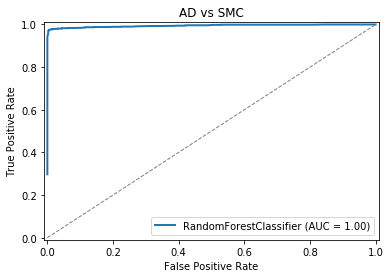

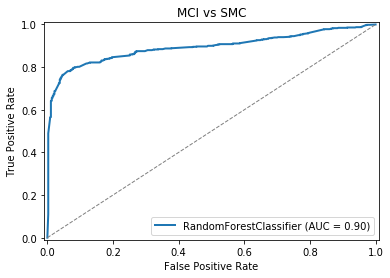

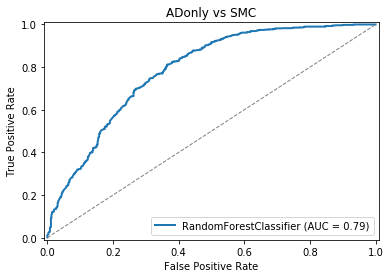

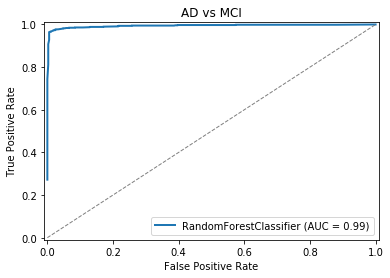

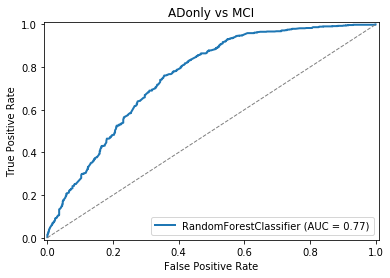

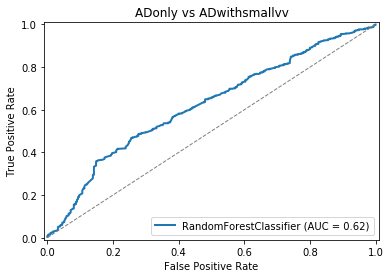

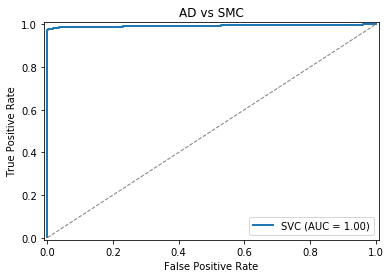

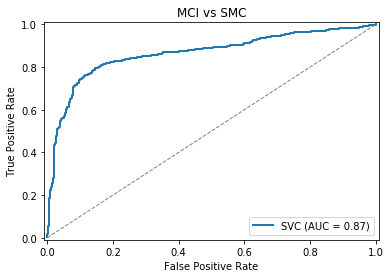

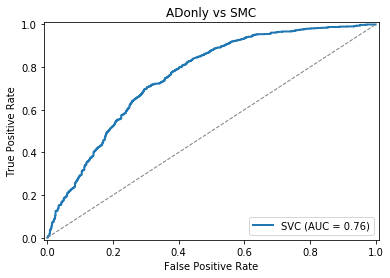

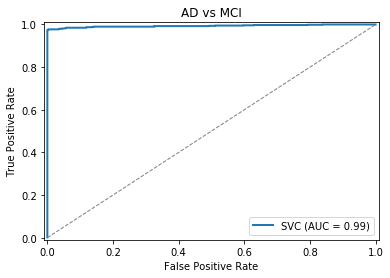

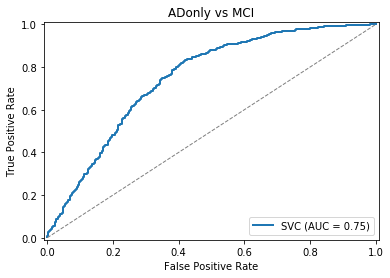

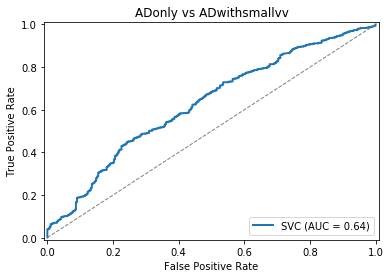

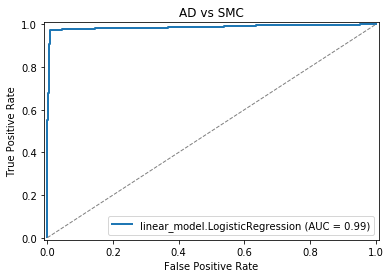

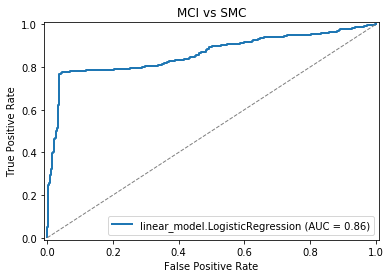

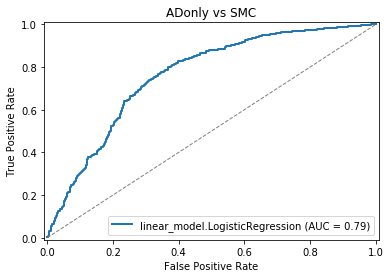

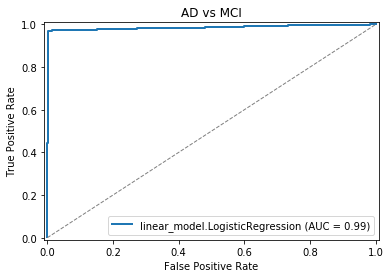

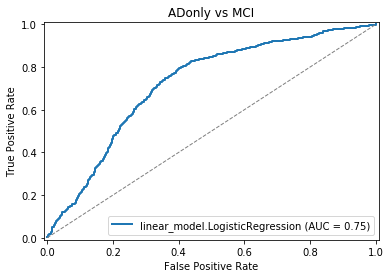

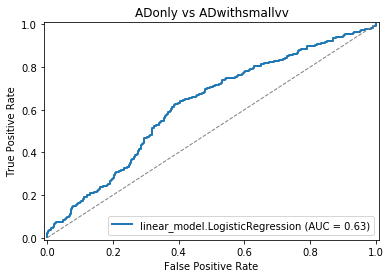

In [8]:
for key, value in models1.items():
    pipe=Pipeline([
                ('featureExtract', SelectFromModel(ExtraTreesClassifier())),
                (key, models1[key])
            ])
    print(key)
    para=params1[key]
    path_to_save=path_save+key
    if not os.path.exists(path_to_save):
        os.mkdir(path_to_save)
    MM=pd.DataFrame()
    SS=pd.DataFrame()
    for i in range(5,11):
            print(save_name[i-5])
            X,y=data_fetch_clean(file,i)

            y = y.reshape(-1)
#             F=SelectFromModel(ExtraTreesClassifier(),prefit=True)
#             X_feature=F.transform(X)
#             list(X_features)
            name=save_name[i-5]
            FD=main_classifier(X,y,name,filename,para,pipe,path_to_save,key)
            M=FD.mean(axis=0)
            
            S=FD.std(axis=0)
            #S.rename(index={S.index[0]: name})
            
            MM=MM.append(M,ignore_index=True)
            MM.rename(index={MM.index[i-5]: name})
            SS=SS.append(S,ignore_index=True)
            SS.rename(index={SS.index[i-5]: name})
    MM.index=save_name
    SS.index=save_name
    writer = pd.ExcelWriter(path_save+key+'_Performance.xlsx')
    MM.to_excel(writer,'Mean')
    SS.to_excel(writer,'SD')
    writer.save()